# Result comparaison for Superpixels Entropy

In [1]:
import time
import json
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import EntropyRateSuperpixel as ERS
import MyDataset as Data
import LambdaCoeff as LC
import ERSBasedSegmentation as SPS
from SNIC import snic_segmentation, SLIC

#import SSGA

512 217 204


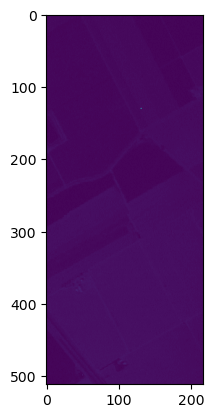

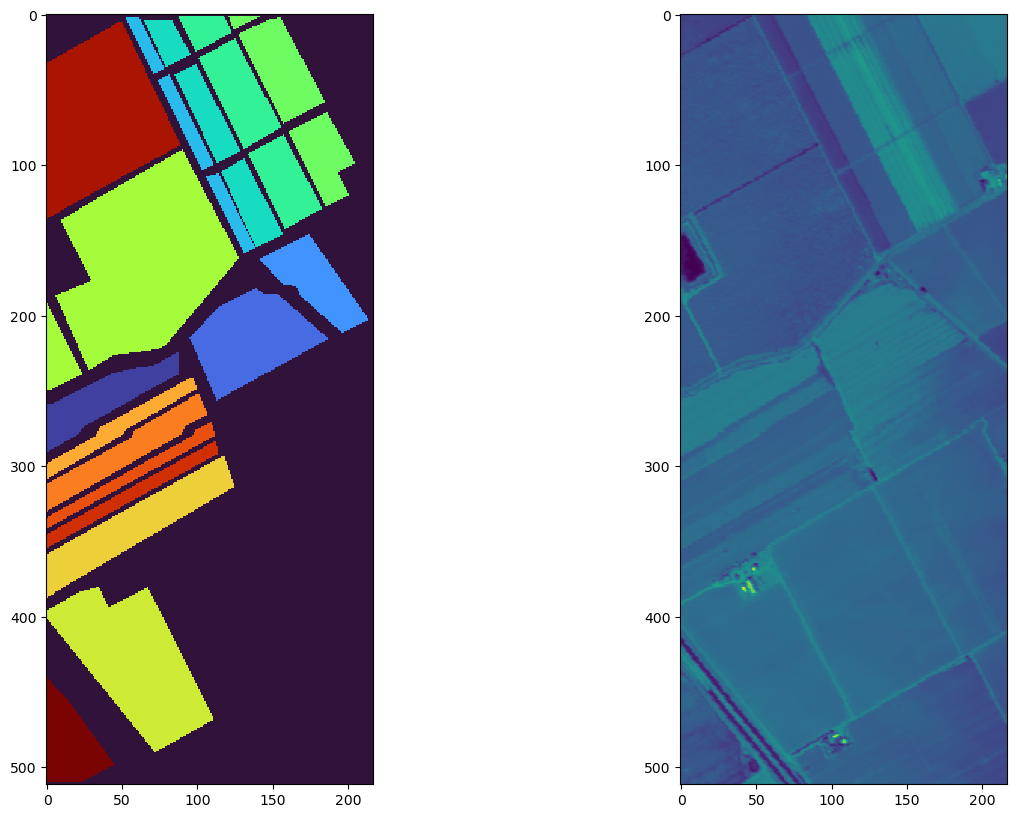

In [2]:
dataset = Data.IndianPines
#dataset = Data.PaviaUniversity
#dataset = Data.PaviaCenter
dataset = Data.SalinasScene

cmap_name = "turbo"
usedDataset = dataset
#usedDataset,_,_ = Data.cropDataset(usedDataset, 200, 200)
N,M,B = usedDataset["shape"]
print(N,M,B)
trainData = Data.standardize_data(usedDataset["data"])

b = np.random.randint(0, B-1)
plt.imshow(trainData[:,:,b])
plt.show()
fig, axs = plt.subplots(1, 2, figsize=(15,10))
axs[0].imshow(usedDataset["gt"], cmap=cmap_name, interpolation="none")
axs[1].imshow(np.average(usedDataset["data"], axis=2))
plt.show()

## Compute SPs

In [3]:
RunDataFormat = False
useLambdasModel = True

datasetFolder = "datasets/"
saved_file_name = {
    True: "FormatDataSuperpixels",
    False: "SimFunSuperpixels"
}

complete_save_file_name = datasetFolder + saved_file_name[RunDataFormat]
if useLambdasModel and not RunDataFormat:
    complete_save_file_name += "UsedLambdasModel"
complete_save_file_name +=  usedDataset["name"] +".json"
print(complete_save_file_name)

datasets/SimFunSuperpixelsUsedLambdasModelSalinas Scene.json


##### Custom computation

In [4]:
Ks = [50, 100, 200, 300, 400, 500, 600]#, 700, 800, 900]
#Ks = [100, 300, 500, 700, 900, 1100, 1300, 1500]
Ks = [20, 50, 100, 200, 300, 500, 700, 900]


names = ["basic"] + ["std"] + ["Norm1"] 
names = ["norm1"]
names = ["base-line", "std-norm1"]


ns_component = [0, 5, 15]
names += ["ML F-norm1 "+str(n) for n in ns_component]
names += ["ML std-F-norm1"]
#names += ["ML std-F-norm1 "+str(n) for n in ns_component]
#names += ["ML F-norm1-std-exp "+str(n) for n in ns_component]
#names += ["ML cwa-F-norm1 "+str(n) for n in ns_component]
#names += ["ML cwa-std-F-norm1 "+str(n) for n in ns_component]

#names += ["ML DBI "+str(n) for n in ns_component]
#names += ["ML Dunn "+str(n) for n in ns_component]
#names += ["ML XBI "+str(n) for n in ns_component]

#names += ["ML F-norm2 "+str(n) for n in ns_component]
#names += ["ML F-std-norm1 "+str(n) for n in ns_component]
#names += ["ML F-std", "ML F-std²", "ML F-std exp", "ML F-std exp2"]
#names += ["ML F-std-exp"]

#names += ["MB F-test sim1"]
#names += ["MB stdF-test²"]
MB_ns_component = [0, 5, 15]
names += ["MB F-norm1 "+str(n) for n in MB_ns_component]
names += ["MB std-F-norm1"]
#names += ["MB std-norm1 "+str(n) for n in MB_ns_component]
#names += ["MB wavg-norm1 "+str(n) for n in MB_ns_component]
#names += ["MB wavg-std-norm1 "+str(n) for n in MB_ns_component]
#names += ["MB perason "+str(n) for n in MB_ns_component]

datas = names
trainData = Data.standardize_data(trainData)
print(names)
print(Ks)

['base-line', 'std-norm1', 'ML F-norm1 0', 'ML F-norm1 5', 'ML F-norm1 15', 'ML std-F-norm1', 'MB F-norm1 0', 'MB F-norm1 5', 'MB F-norm1 15', 'MB std-F-norm1']
[20, 50, 100, 200, 300, 500, 700, 900]


In [5]:
SPsDic = {K:[] for K in Ks}
timeDic = {K:[] for K in Ks}

In [6]:
# State of the art comp
names = ["SLIC", "SNIC", "ERS", "proposed"]
datas = names

starting_time = time.time()
pca_data = SPS.compute_false_greyscale_img(usedDataset["data"])
pca_time = time.time() - starting_time


print("SLIC")
for K in Ks:
    starting_time = time.time()
    SPs = SLIC(pca_data, K, compactness=Data.hyperparameterValue[usedDataset["name"]][K][0])
    timeDic[K].append(time.time()-starting_time + pca_time)
    SPsDic[K].append(SPs)


print("SNIC")
for K in Ks:
    starting_time = time.time()
    SPs = snic_segmentation(pca_data, K, compactness=Data.hyperparameterValue[usedDataset["name"]][K][1])
    timeDic[K].append(time.time()-starting_time + pca_time)
    SPsDic[K].append(SPs)


print("ERS")
lc = [Data.hyperparameterValue[usedDataset["name"]][K][2] for K in Ks]
SPs_dic_i, dic_time = ERS.find_superpixel(pca_data, Ks, lambda_coef=lc, simFun="average", updateLambda=True, time_info=True)
for K in Ks:
    SPsDic[K].append(SPs_dic_i[K])
    timeDic[K].append(dic_time[K] + pca_time)

print("proposed")
starting_time = time.time()
infos = SPS.computeMergeBasedInfo(trainData, n_component=0)
info_time = time.time() - starting_time

SPs_dic_i, dic_time = SPS.mergedBasedSegmentation(trainData, Ks, infos=infos, usedVarFun=SPS.stdFtestnorm1, dist=(2,""), n_component=0, info_time=True)
for K in Ks:
    SPsDic[K].append(SPs_dic_i[K])
    timeDic[K].append(dic_time[K] + info_time)

SLIC
SNIC
ERS
proposed


In [ ]:
# MethodComp names
names = ["std-norm1"]

ns_component = [0, 5, 15]
names += ["ML F-norm1 "+str(n) for n in ns_component] + ["ML std-F-norm1"]

MB_ns_component = [0, 5, 15]
names += ["MB F-norm1 "+str(n) for n in MB_ns_component] + ["MB std-F-norm1"]
datas = names

print("norm1")
SPs_dic_i, dic_time = ERS.find_superpixel(trainData, Ks, lambda_coef="auto", simFun="norm1", updateLambda=True, time_info=True)
for K in Ks:
    SPsDic[K].append(SPs_dic_i[K])
    timeDic[K].append(dic_time[K])

print("ML std norm1")
starting_time = time.time()
Ks_or = SPS.compute_Ks(N,M)
infos = SPS.createMultilevelInfo(trainData, Ks_or)
info_time = time.time() - starting_time

for n in ns_component:
    print(n, end=" ")
    SPs_dic_i, dic_time = SPS.multilevelSPsegmentation(trainData, Ks, n_component=n, infos=infos, info_time=True)
    for K in Ks:
        SPsDic[K].append(SPs_dic_i[K])
        timeDic[K].append(dic_time[K] + info_time)
print("std")
SPs_dic_i, dic_time = SPS.multilevelSPsegmentation(trainData, Ks, n_component=0, infos=infos, varFun=SPS.stdFtestnorm1, dist=(2,""), info_time=True)
for K in Ks:
    SPsDic[K].append(SPs_dic_i[K])
    timeDic[K].append(dic_time[K] + info_time)


print("MB std norm1")
infosDic = {}
infos_time_dic = {}
for n in MB_ns_component:
    starting_time = time.time()
    infosDic[n] =  SPS.computeMergeBasedInfo(trainData, n_component=n)
    infos_time_dic[n] = time.time() - starting_time


for n in MB_ns_component:
    print(n, end=" ")
    SPs_dic_i, dic_time = SPS.mergedBasedSegmentation(trainData, Ks, infos=infosDic[n], n_component=n, info_time=True)
    for K in Ks:
        SPsDic[K].append(SPs_dic_i[K])
        timeDic[K].append(dic_time[K] + infos_time_dic[n])

print("std")
SPs_dic_i, dic_time = SPS.mergedBasedSegmentation(trainData, Ks, infos=infosDic[0], usedVarFun=SPS.stdFtestnorm1, dist=(2,""), n_component=0, info_time=True)
for K in Ks:
    SPsDic[K].append(SPs_dic_i[K])
    timeDic[K].append(dic_time[K] + infos_time_dic[0])

In [ ]:
# MB names
MB_ns_component = [0, 3, 5, 10, 15]
names = []
names += ["MB norm1"+str(n) for n in MB_ns_component]
names += ["MB std-norm1 "+str(n) for n in MB_ns_component]
names += ["MB wavg-norm1"+str(n) for n in MB_ns_component]
names += ["MB wavg-std-norm1"+str(n) for n in MB_ns_component]
datas = names

infosDic = {n: SPS.computeMergeBasedInfo(trainData, n_component=n) for n in MB_ns_component}

for n in MB_ns_component:
    print(n)
    SPs_dic_i = SPS.mergedBasedSegmentation(trainData, Ks, infos=infosDic[n], n_component=n)
    for K in Ks:
        SPsDic[K].append(SPs_dic_i[K])

for n in MB_ns_component:
    print(n)
    SPs_dic_i = SPS.mergedBasedSegmentation(trainData, Ks, infos=infosDic[n], usedVarFun=SPS.stdFtestnorm1, dist=(1,""), n_component=n)
    for K in Ks:
        SPsDic[K].append(SPs_dic_i[K])

for n in MB_ns_component:
    print(n)
    SPs_dic_i = SPS.mergedBasedSegmentation(trainData, Ks, infos=infosDic[n], n_component=n, weighted_avg=True)
    for K in Ks:
        SPsDic[K].append(SPs_dic_i[K])

for n in MB_ns_component:
    print(n)
    SPs_dic_i = SPS.mergedBasedSegmentation(trainData, Ks, infos=infosDic[n], usedVarFun=SPS.stdFtestnorm1, dist=(1,""), n_component=n, weighted_avg=True)
    for K in Ks:
        SPsDic[K].append(SPs_dic_i[K])


In [ ]:
# ML names
MB_ns_component = [0, 3, 5, 10, 15]
names = []
names += ["ML norm1 "+str(n) for n in MB_ns_component]
names += ["ML std-norm1 "+str(n) for n in MB_ns_component]
names += ["ML wavg-norm1 "+str(n) for n in MB_ns_component]
names += ["ML wavg-std-norm1 "+str(n) for n in MB_ns_component]
datas = names

Ks_or = SPS.compute_Ks(N,M)
print("info")
infos = SPS.createMultilevelInfo(trainData, Ks_or)

for n in ns_component:
    print(n)
    SPs_dic_i = SPS.multilevelSPsegmentation(trainData, Ks, n_component=n, infos=infos)
    for K in Ks:
        SPsDic[K].append(SPs_dic_i[K])
    
for n in ns_component:
    print(n)
    SPs_dic_i = SPS.multilevelSPsegmentation(trainData, Ks, n_component=n, infos=infos, varFun=SPS.stdFtestnorm1, dist=(1,""))
    for K in Ks:
        SPsDic[K].append(SPs_dic_i[K])

for n in ns_component:
    print(n)
    SPs_dic_i = SPS.multilevelSPsegmentation(trainData, Ks, n_component=n, infos=infos, weighted_avg=True)
    for K in Ks:
        SPsDic[K].append(SPs_dic_i[K])

for n in ns_component:
    print(n)
    SPs_dic_i = SPS.multilevelSPsegmentation(trainData, Ks, n_component=n, infos=infos, varFun=SPS.stdFtestnorm1, dist=(1,""), weighted_avg=True)
    for K in Ks:
        SPsDic[K].append(SPs_dic_i[K])


In [ ]:
print("basic")
SPs_dic_i = ERS.find_superpixel(usedDataset["data"], Ks, lambda_coef=1, simFun="average", updateLambda=False)
for K in Ks:
    SPsDic[K].append(SPs_dic_i[K])

print("standardized average")
SPs_dic_i = ERS.find_superpixel(trainData, Ks, lambda_coef="auto",simFun="average", updateLambda=True)
for K in Ks:
    SPsDic[K].append(SPs_dic_i[K])

print("norm1")
SPs_dic_i = ERS.find_superpixel(trainData, Ks, lambda_coef="auto",simFun="norm1", updateLambda=True)
for K in Ks:
    SPsDic[K].append(SPs_dic_i[K])

##### classic computation

In [39]:
if RunDataFormat:
    data1 = usedDataset["data"].copy()
    data2 = Data.normalized_data(usedDataset["data"].copy())
    data3 = Data.standardize_data( usedDataset["data"].copy() )
    datas = [data1, data2, data3]
    names = ["Basic", "Normalized", "Standardized"]
else:
    datas = ["average", "norm2", "norm1", "perason"]
    names = ["Average", "Norm2", "Norm1", "Perason"]
    trainData = Data.standardize_data(trainData)
    getLambdas = [LC.getLambdaAverage, LC.getLambdaNorm2, LC.getLambdaNorm1]


FoundLambdaCoeffKey = "DataFormat" if RunDataFormat else "SimilarityFunction"
LambdaCoeffs = Data.FoundLambdaCoeff[FoundLambdaCoeffKey]


if usedDataset["name"] in [Data.IndianPines["name"], Data.PaviaUniversity["name"]]:
    Ks = list(LambdaCoeffs[usedDataset["name"]].keys())
else:
    Ks = [100, 200, 300, 400, 500, 600]

Ks = [200, 500, 800, 1200, 1500, 1800, 2100]
    
if len(Ks)==1:
    complete_save_file_name = complete_save_file_name[:len(complete_save_file_name)-5] + str(Ks[0]) + "SP.json"
    print(complete_save_file_name)
Ks.sort(key=lambda x:x)

print(trainData.shape)
print(Ks)

(512, 217, 204)
[200, 500, 800, 1200, 1500, 1800, 2100]


In [ ]:
def compute_SPs(Ks, save_data=False, find_lambda=True):
    SPsDic = {K:[] for K in Ks}

    if (not RunDataFormat) and useLambdasModel:
        for i,funName in enumerate(datas):
            print("i =", i, "(" + funName + ")")
            SPs_dic_i = ERS.find_superpixel(trainData, Ks,
                                           lambda_coef="auto",
                                           simFun=funName,
                                           updateLambda=True)
            for K in Ks:
                SPsDic[K].append(SPs_dic_i[K])
    
    else:
        SPsDic = {}
        for K in Ks:
            print("K:", K)
            Ps = LC.computePs(K, N, M)

            current_list = []
            for i,data in enumerate(datas):
                print(i, end=" ")
                if RunDataFormat:

                    fun = ERS.create_CSF("average", data)
                    if find_lambda:
                        SPs, coeff = LC.dichotomies_search(data, K, 1, 400, fun, Ps)
                        print("Choosen Coef:", coeff)
                    else:
                        SPs = ERS.find_superpixel(data, K,
                                                lambda_coef=LambdaCoeffs[usedDataset["name"]][K][i],
                                                simFun="average")
                else:
                    if find_lambda:
                        fun = ERS.create_CSF(data, trainData)
                        SPs, coeff = LC.dichotomies_search(trainData, K, 1, 400, fun, Ps)
                        print("Choosen Coef:", coeff)
                    else:
                        lc = LambdaCoeffs[usedDataset["name"]][K][i]
                        SPs = ERS.find_superpixel(trainData, K,
                                                    lambda_coef=lc,
                                                    simFun=data)
                current_list.append(SPs)
            print()
            SPsDic[K] = current_list


    if save_data:
        json_object = json.dumps(SPsDic)
        with open(complete_save_file_name, "w") as f :
            f.write(json_object)
            f.close()
    return SPsDic


SPsDic = compute_SPs(Ks, save_data=True, find_lambda=False)

i = 0 (average)
i = 1 (norm2)
i = 2 (norm1)
i = 3 (perason)


##### Open/Save SPs

In [4]:
json_object = json.dumps(SPsDic)
with open("datasets/ML " + usedDataset["name"] + ".json", "w") as f :
    f.write(json_object)
    f.close()

NameError: name 'SPsDic' is not defined

In [4]:
with open("datasets/ML " + usedDataset["name"] + ".json", "r") as f:
    tempDic = json.load(f)
    f.close()
SPsDic = {}
for key, dataListe in tempDic.items():
    SPsDic[int(key)] = [[[tuple(coor) for coor in SP] for SP in SPsListe] for SPsListe in dataListe]

Ks = list(SPsDic.keys())
Ks.sort()

In [8]:
DicAll = {"SP": SPsDic, "time":timeDic}
json_object = json.dumps(DicAll)
with open("datasets/All " + usedDataset["name"] + ".json", "w") as f :
    f.write(json_object)
    f.close()

In [9]:
with open("datasets/All " + usedDataset["name"] + ".json", "r") as f:
    tempDic = json.load(f)
    f.close()
SPsDic = {}
for key, dataListe in tempDic["SP"].items():
    SPsDic[int(key)] = [[[tuple(coor) for coor in SP] for SP in SPsListe] for SPsListe in dataListe]
Ks = list(SPsDic.keys())
Ks.sort()

timeDic = {}
for key, dataListe in tempDic["time"].items():
    timeDic[int(key)] = [float(t) for t in dataListe]

In [40]:
with open(complete_save_file_name, "r") as f:
    tempDic = json.load(f)
    f.close()
SPsDic = {}
for key, dataListe in tempDic.items():
    SPsDic[int(key)] = [[[tuple(coor) for coor in SP] for SP in SPsListe] for SPsListe in dataListe]

Ks = list(SPsDic.keys())
Ks.sort()

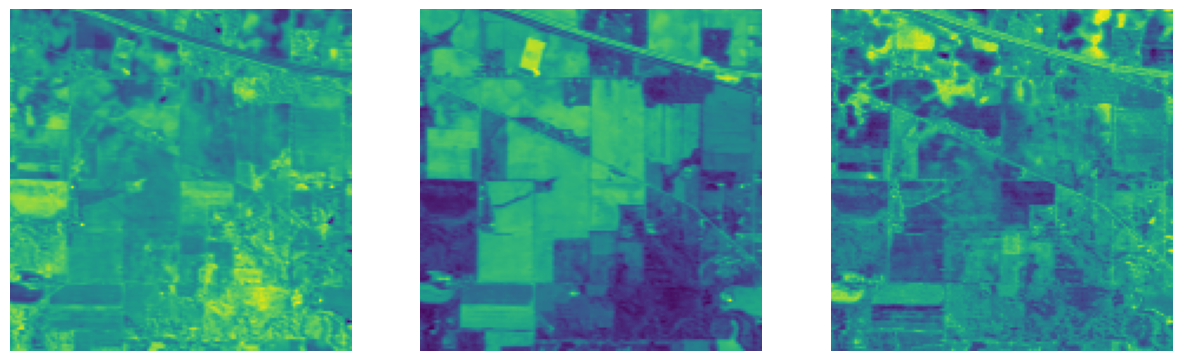

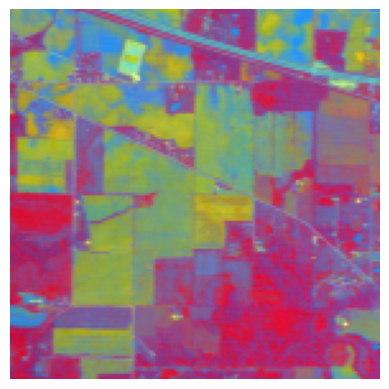

In [ ]:
pca_data = SPS.compute_false_greyscale_img(usedDataset["data"])
fig, axs=  plt.subplots(1,3, figsize=(15,10))
for i in range(3):
    axs[i].imshow(pca_data[:,:,i])
    axs[i].axis("off")
plt.show()

plt.imshow((Data.normalized_data(pca_data)*255).astype(int))
plt.axis("off")
plt.show()

### Superpixels Classifier

In [7]:
ClassifierDic:dict[int, list[ERS.SuperpixelClassifier]] = {}
for b in [True, False]:
    print(b)
    ClassifierDic[b] = {}
    for K in Ks:
        ClassifierDic[b][K] = [
            ERS.SuperpixelClassifier(SPs, usedDataset["labels"], usedDataset["gt"], counting0=b)
                    for SPs in SPsDic[K]
            ]

True
False


### Visual result

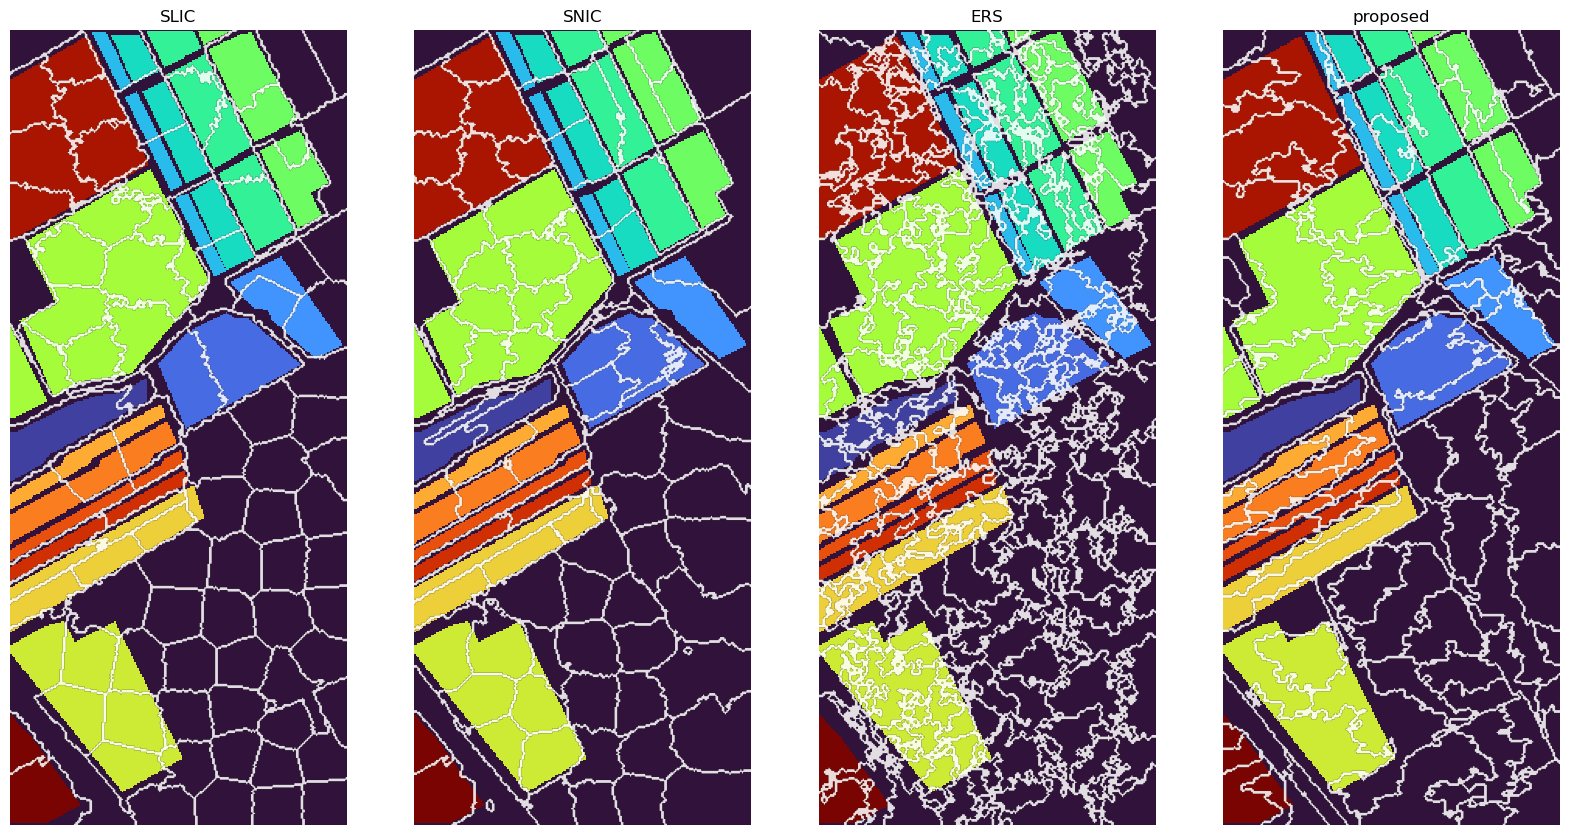

True


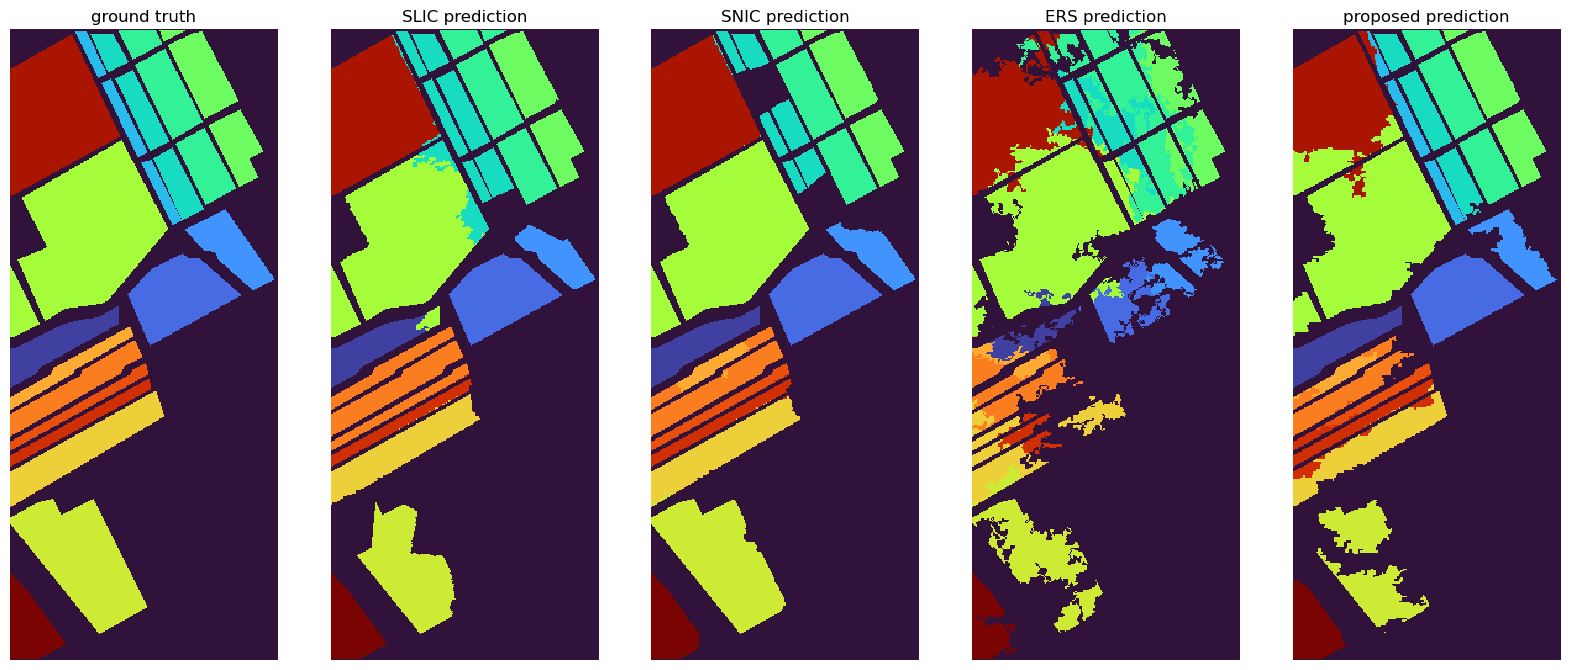

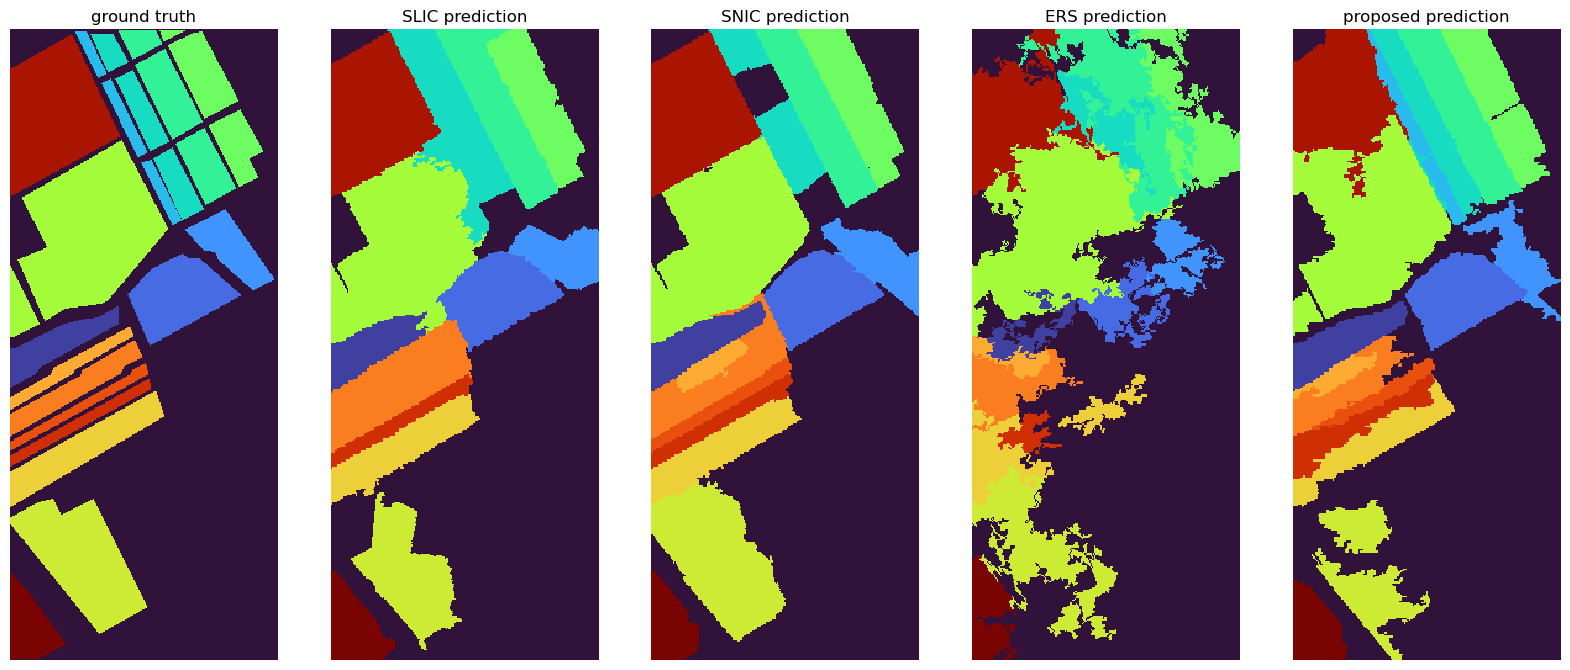

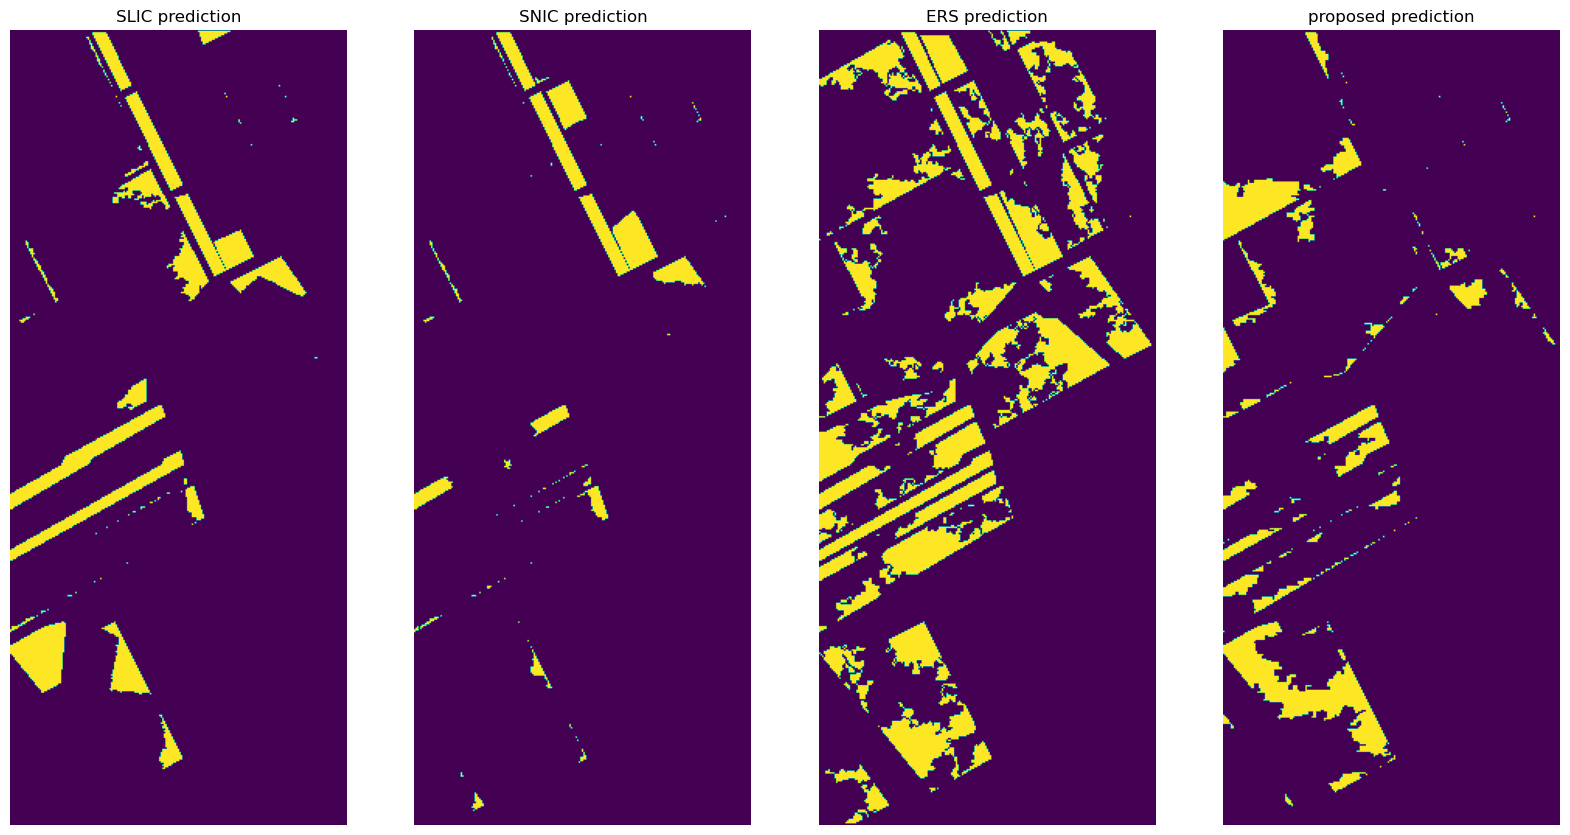

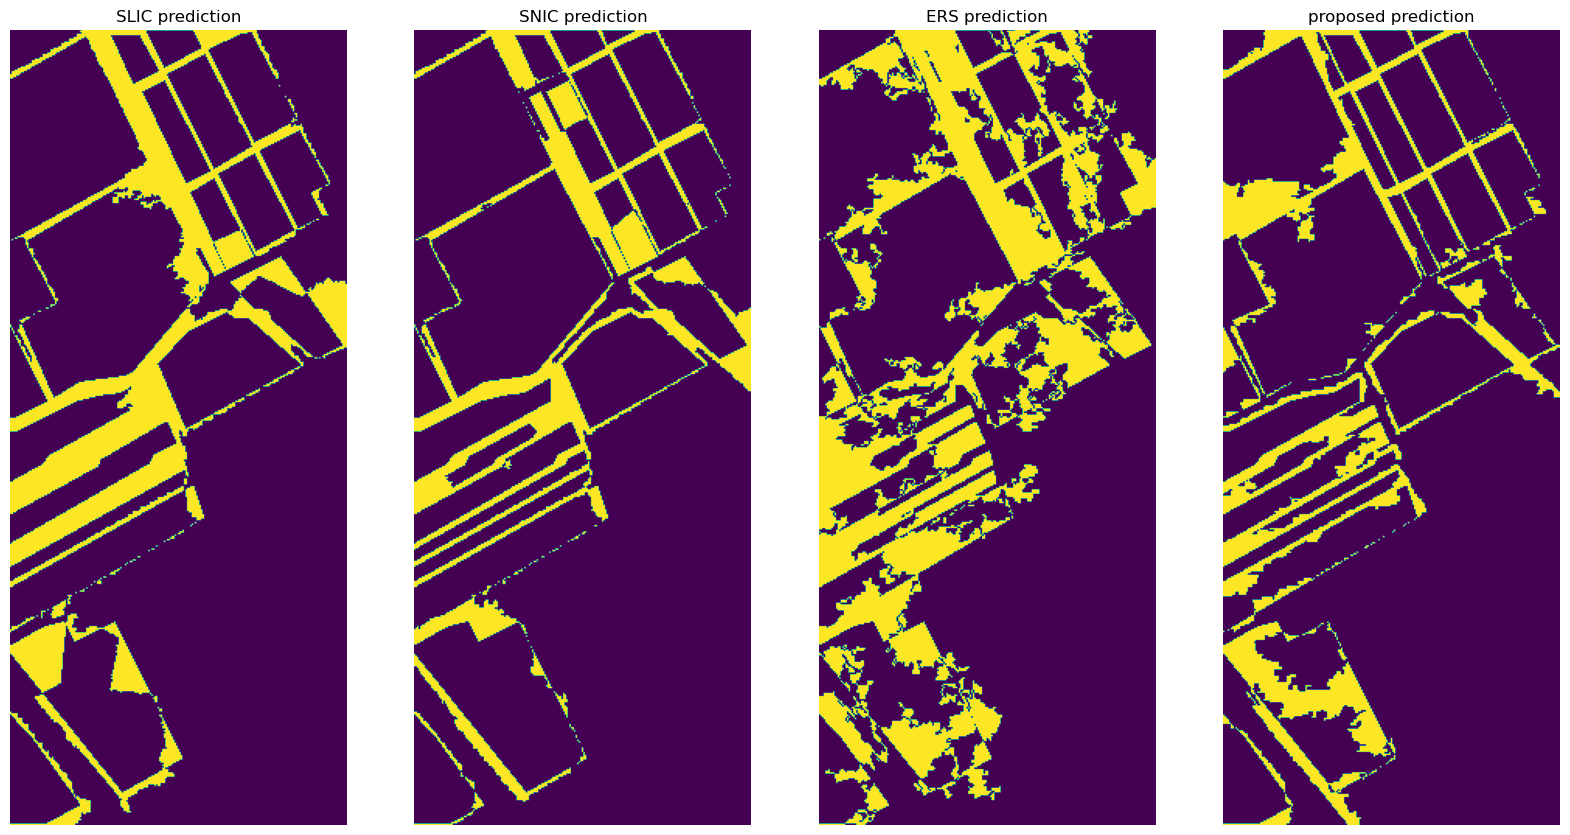

False


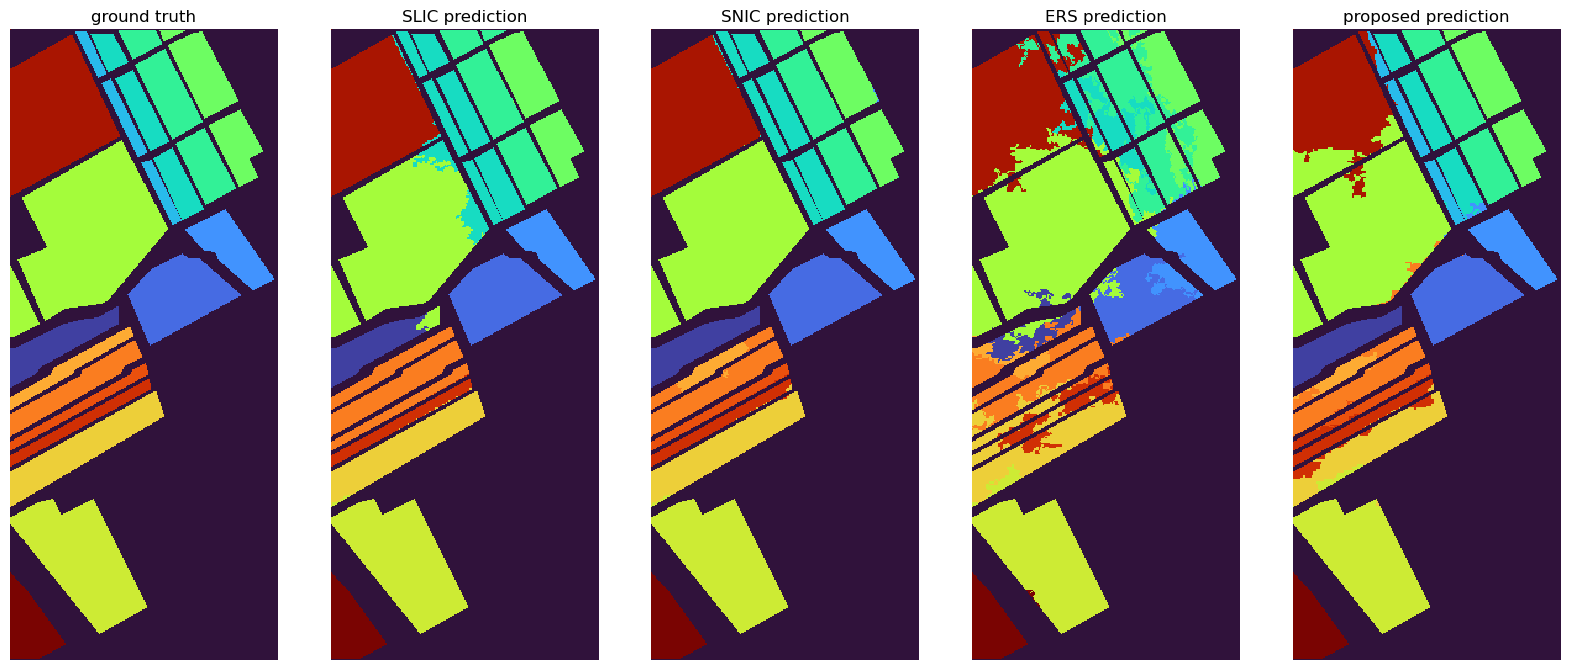

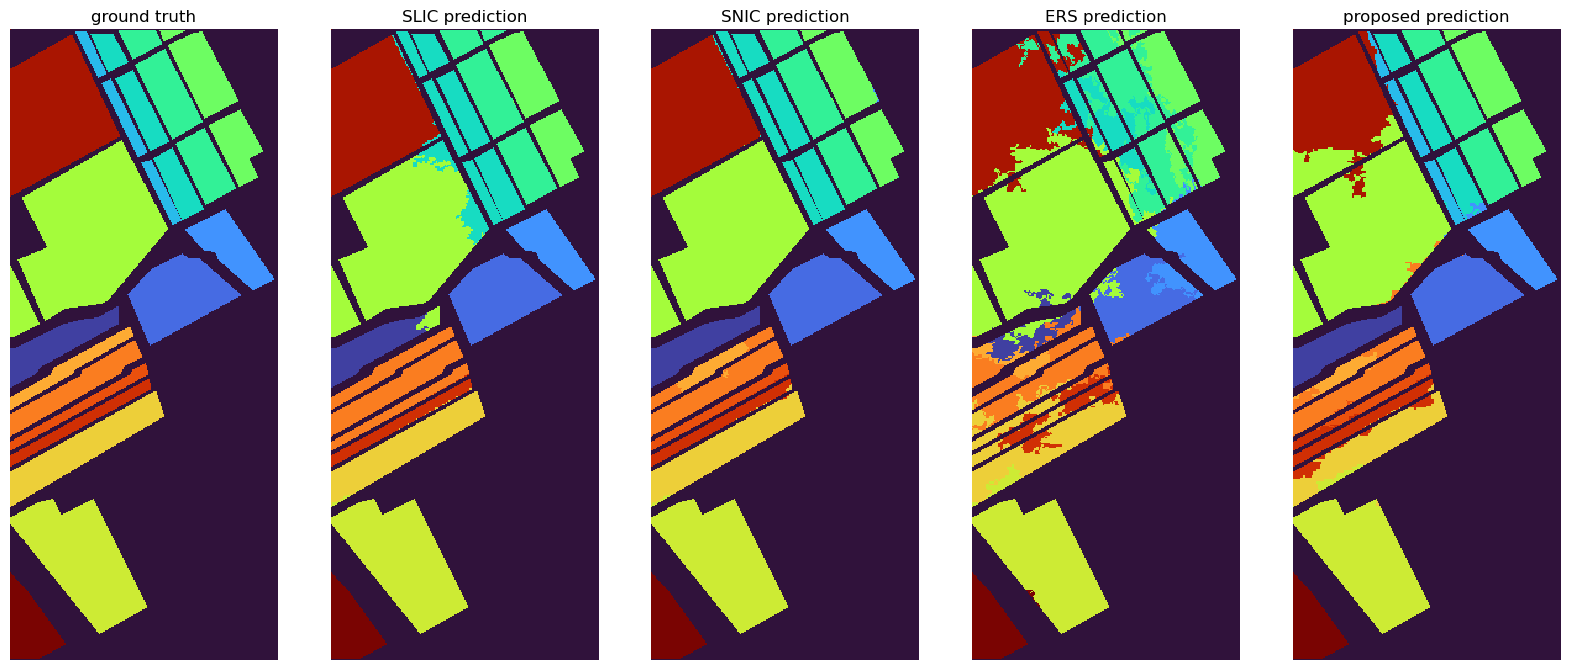

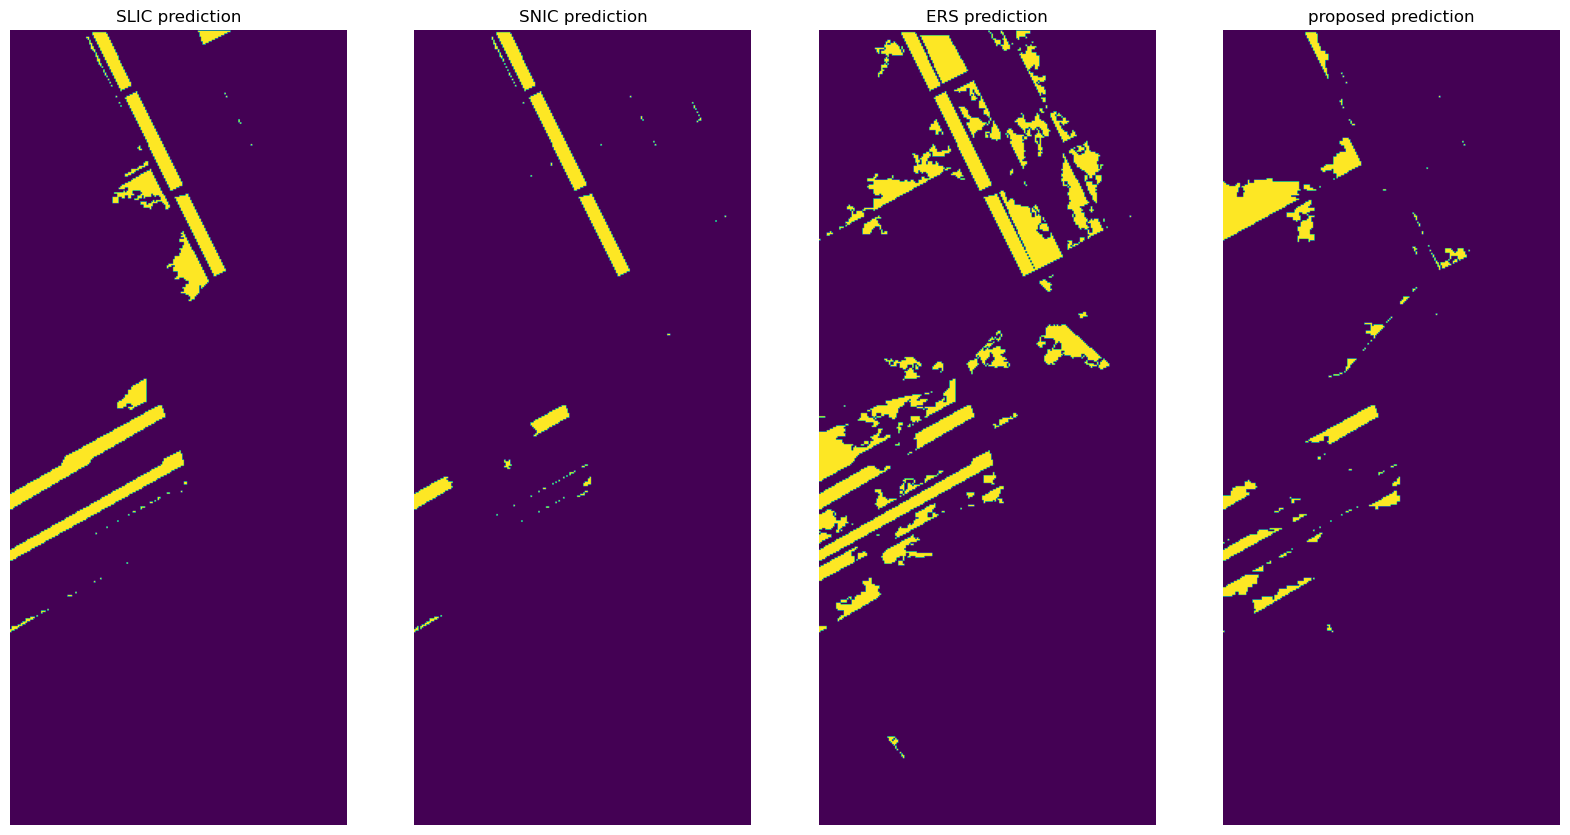

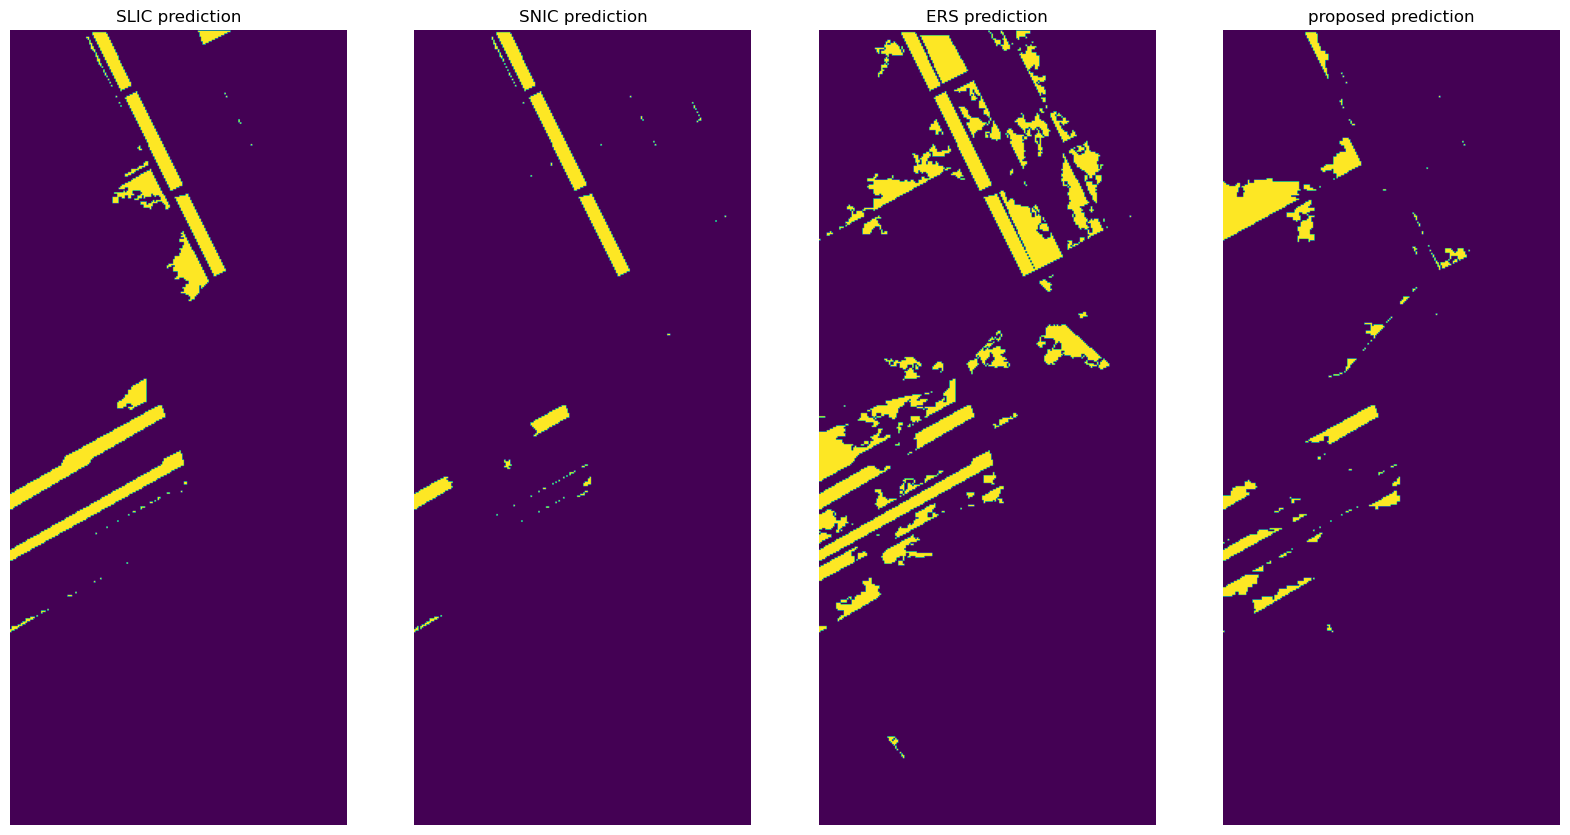

In [12]:
K = 100
ids = [i for i in range(len(names))]
#ids = [0,1,2,3,4]
#ids = [5,6,7,8,9]

fig, axs = plt.subplots(1, len(ids))
fig.set_size_inches(20,30)
for i in range(len(ids)):
    SP = SPsDic[K][ids[i]]
    axs[i].imshow(usedDataset["gt"], cmap=cmap_name, interpolation="none")
    axs[i].imshow(ERS.create_overlay_borders(usedDataset["gt"], SP, color=[255,255,255,220]))
    axs[i].title.set_text(names[ids[i]])
    axs[i].axis("off")
plt.show()



for b in [True, False]:
    print(b)
    classifiers = ClassifierDic[b][K]


    imgs = [usedDataset["gt"]] + [ClassifierDic[b][K][id].guess_map for id in ids]
    #imgs = [usedDataset["gt"]] + [C.guess_map for C in classifiers]
    titles = ["ground truth"] + [names[id]+" prediction" for id in ids]


    fig, axs = plt.subplots(1, len(imgs))
    fig.set_size_inches(20,30)
    for i in range(len(imgs)):
        new_img = imgs[i].copy()
        for x in range(N):
            for y in range(M):
                if usedDataset["gt"][x,y]==0:
                    new_img[x,y] = 0
        new_img[0,0] = max(usedDataset["labels"])
        axs[i].imshow(new_img, cmap=cmap_name, interpolation="none")
        axs[i].title.set_text(titles[i])
        axs[i].axis("off")
    plt.show()


    fig, axs = plt.subplots(1, len(imgs))
    fig.set_size_inches(20,30)
    for i in range(len(imgs)):
        new_img = imgs[i].copy()
        new_img[0,0] = max(usedDataset["labels"])
        axs[i].imshow(new_img, cmap=cmap_name, interpolation="none")
        axs[i].title.set_text(titles[i])
        axs[i].axis("off")
    plt.show()


    fig, axs = plt.subplots(1, len(ids))
    fig.set_size_inches(20,30)
    for i in range(1, len(imgs)):
        new_img = np.zeros((N,M))
        for x in range(N):
            for y in range(M):
                if usedDataset["gt"][x,y]!=0 and usedDataset["gt"][x,y]!=imgs[i][x,y]:
                    new_img[x,y] = 1

        axs[i-1].imshow(new_img)
        axs[i-1].title.set_text(titles[i])
        axs[i-1].axis("off")
    plt.show()

    fig, axs = plt.subplots(1, len(ids))
    fig.set_size_inches(20,30)
    for i in range(1, len(imgs)):
        new_img = np.zeros((N,M))
        for x in range(N):
            for y in range(M):
                if usedDataset["gt"][x,y]!=imgs[i][x,y]:
                    new_img[x,y] = 1

        axs[i-1].imshow(new_img)
        axs[i-1].title.set_text(titles[i])
        axs[i-1].axis("off")
    plt.show()


### Classification result

In [9]:
size = len(ClassifierDic[True][Ks[0]])
overallAccuracys = {b:{K:[0 for _ in range(size)] for K in Ks} for b in [True,False]}
averageAccuracys = {b:{K:[0 for _ in range(size)] for K in Ks} for b in [True,False]}
averageWeightedJaccard = {b:{K:[0 for _ in range(size)] for K in Ks} for b in [True,False]}
#singleClassCounts = {b:{K:[0 for _ in range(size)] for K in Ks} for b in [True,False]}
averageWeightedProportions = {b:{K:[0 for _ in range(size)] for K in Ks} for b in [True,False]}
undersegmentationErrors = {b:{K:[0 for _ in range(size)] for K in Ks} for b in [True,False]}
#undersegmentationErrorsNo = {b:{K:[0 for _ in range(size)] for K in Ks} for b in [True,False]}
#boundaryRecalls = {b:{K:[0 for _ in range(size)] for K in Ks} for b in [True,False]}

labelsAccuracy = {b:{
        l:{K:[0 for _ in range(size)] for K in Ks} for l in usedDataset["labels"]
    } for b in [True, False]}
labelsJaccard = {b:{
        l:{K:[0 for _ in range(size)] for K in Ks} for l in usedDataset["labels"]
    } for b in [True, False]}

for b in [True, False]:
    print(b)
    for K in Ks:
        for i,C in enumerate(ClassifierDic[b][K]):
            overallAccuracys[b][K][i] = C.overallAccuracy(usedDataset["gt"])
            averageAccuracys[b][K][i] = C.averageAccuracy(usedDataset["gt"])
            averageWeightedJaccard[b][K][i] = C.averageWeightedJaccard(usedDataset["gt"], usedDataset["class"])
            #singleClassCounts[b][K][i] = C.singleClassProportion()
            averageWeightedProportions[b][K][i] = C.averageWeightedProportion()
            undersegmentationErrors[b][K][i] = C.undersegmentationError(usedDataset["class"], unique_overlap=True)
            #undersegmentationErrorsNo[b][K][i] = C.undersegmentationError(usedDataset["class"], unique_overlap=False)
            #boundaryRecalls[b][K][i] = C.boundaryRecall(usedDataset["gt"])
        
            for label in usedDataset["labels"]:
                if label in C.labels:
                    labelsAccuracy[b][label][K][i] = C.labelAccuracy(usedDataset["class"], label)
                    labelsJaccard[b][label][K][i] = C.jaccard(usedDataset["gt"], usedDataset["class"], label)
        

True
False


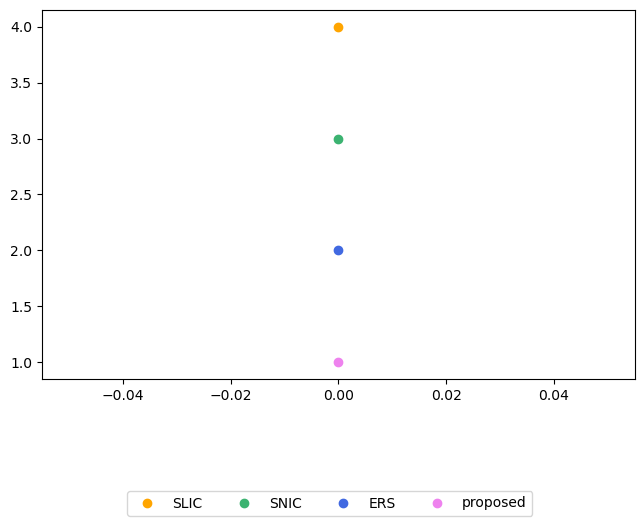

True


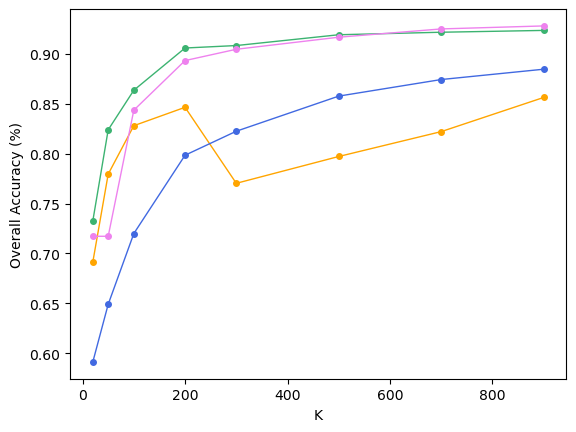

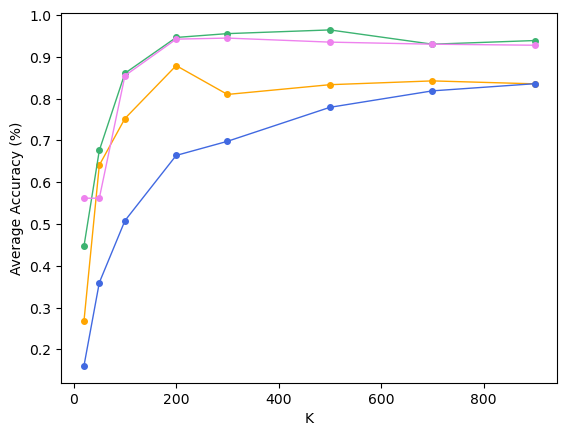

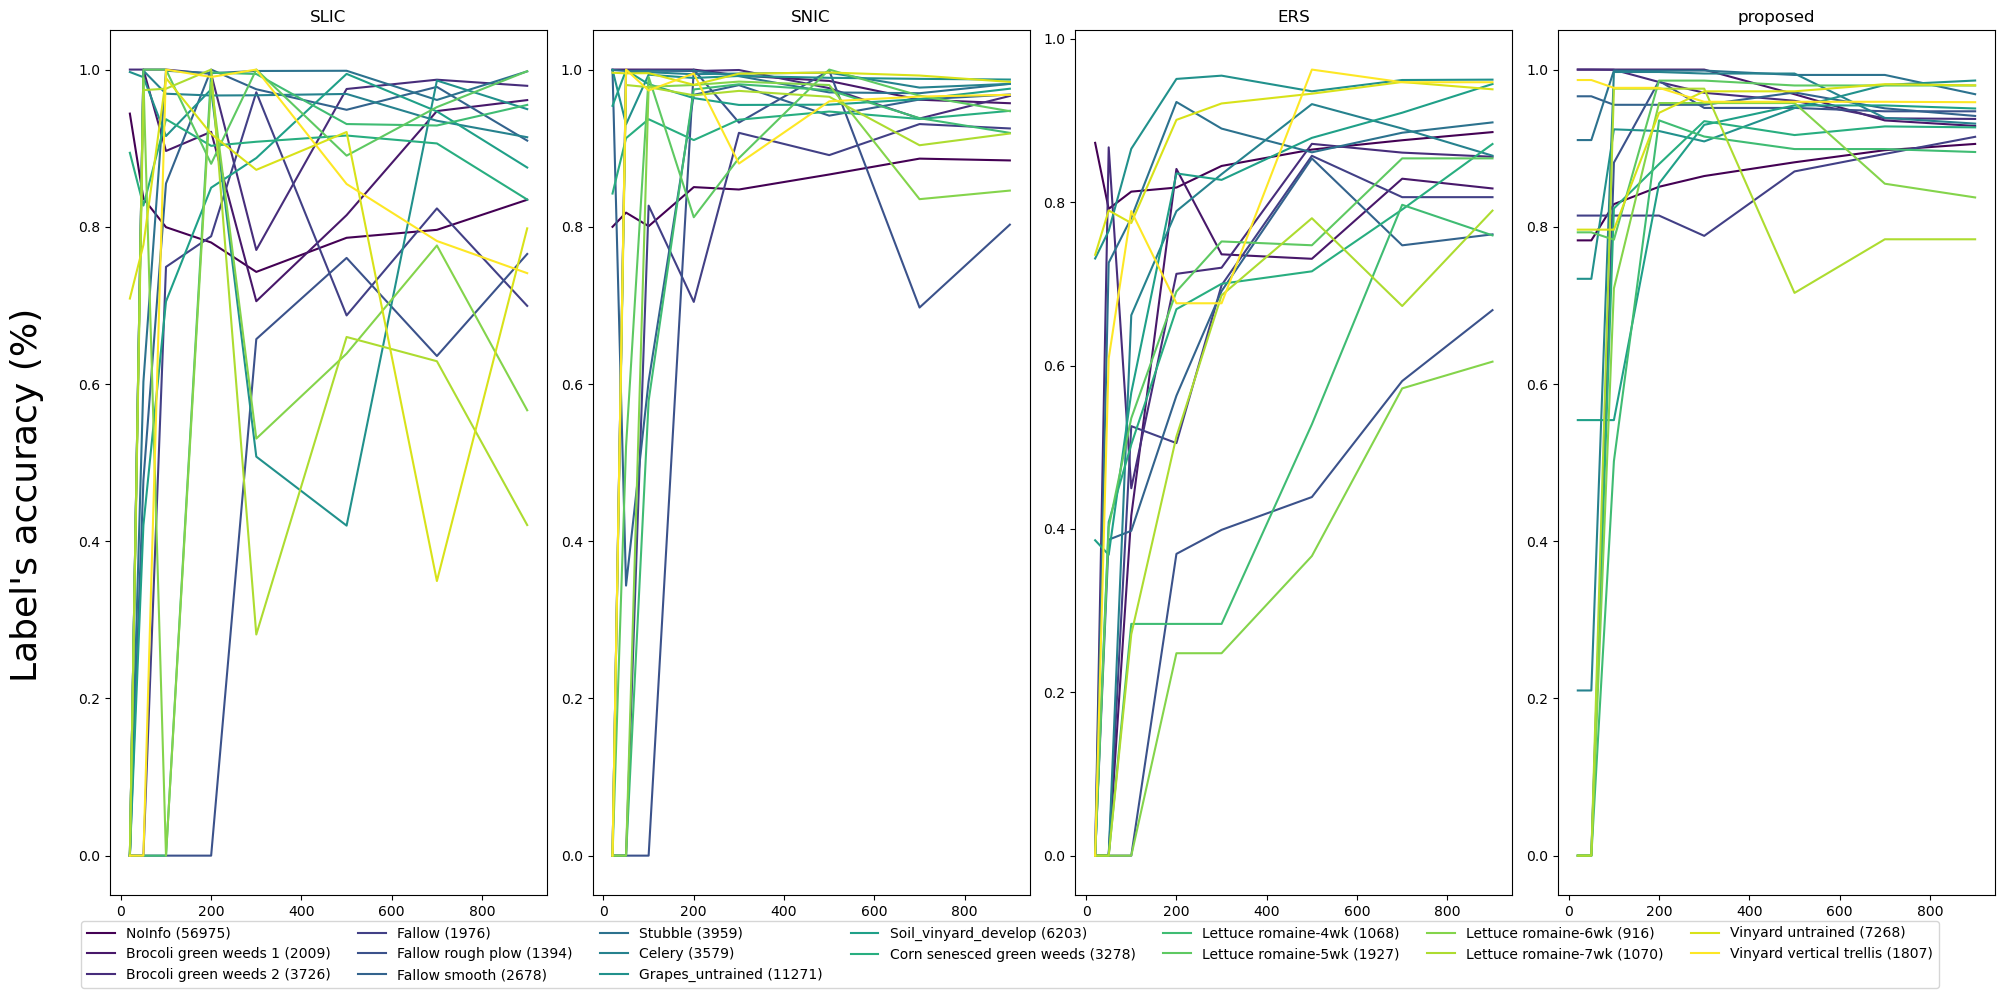

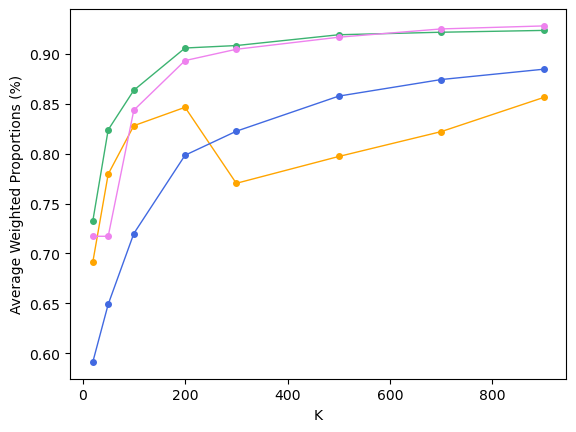

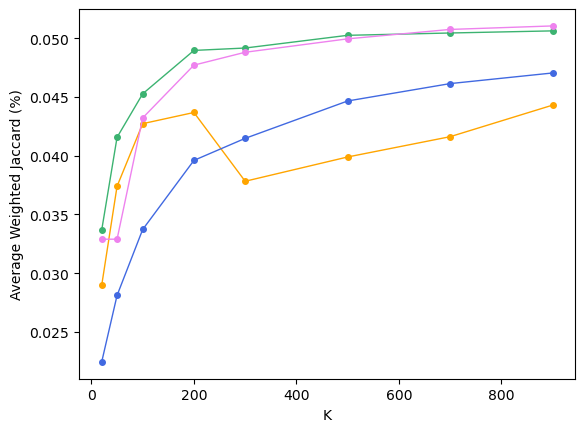

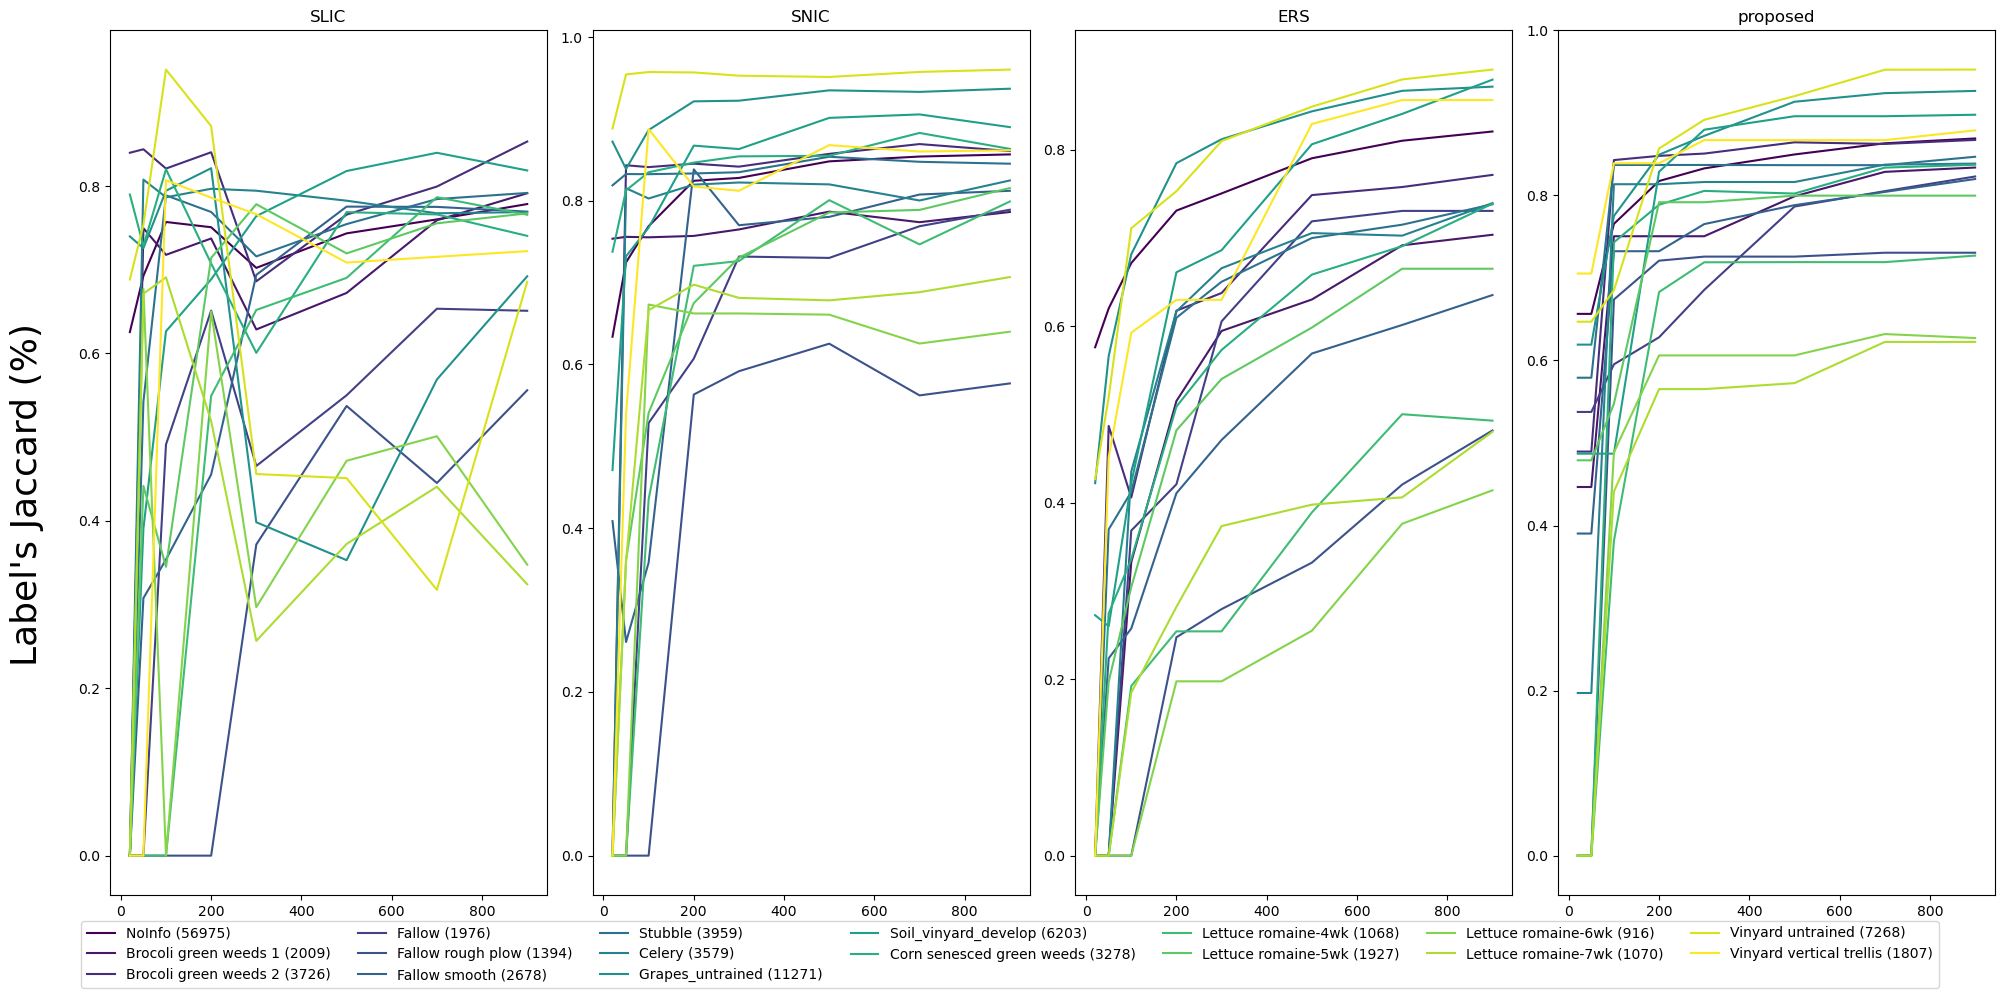

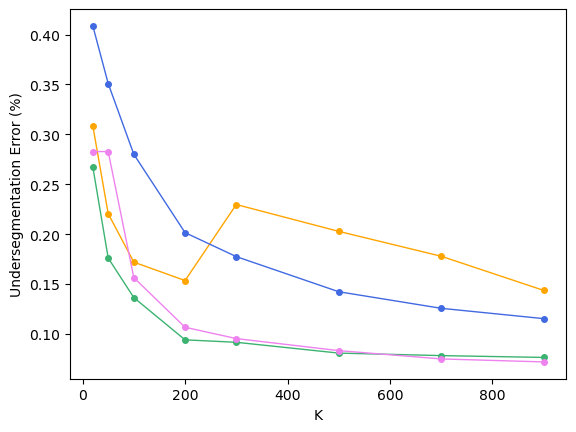

False


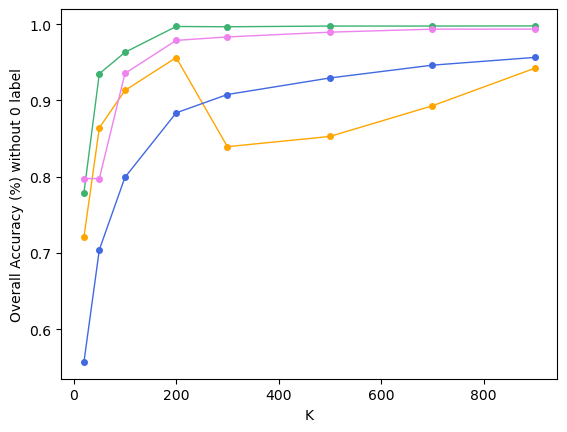

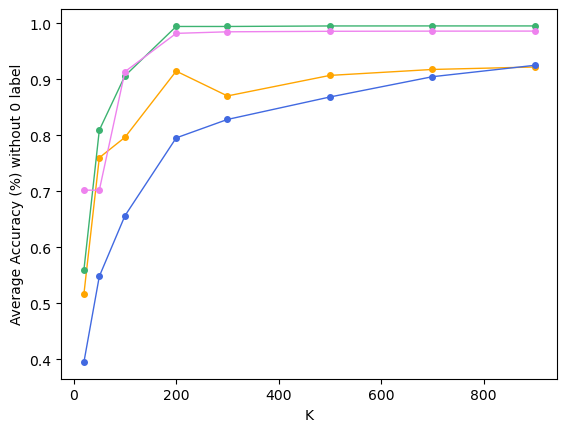

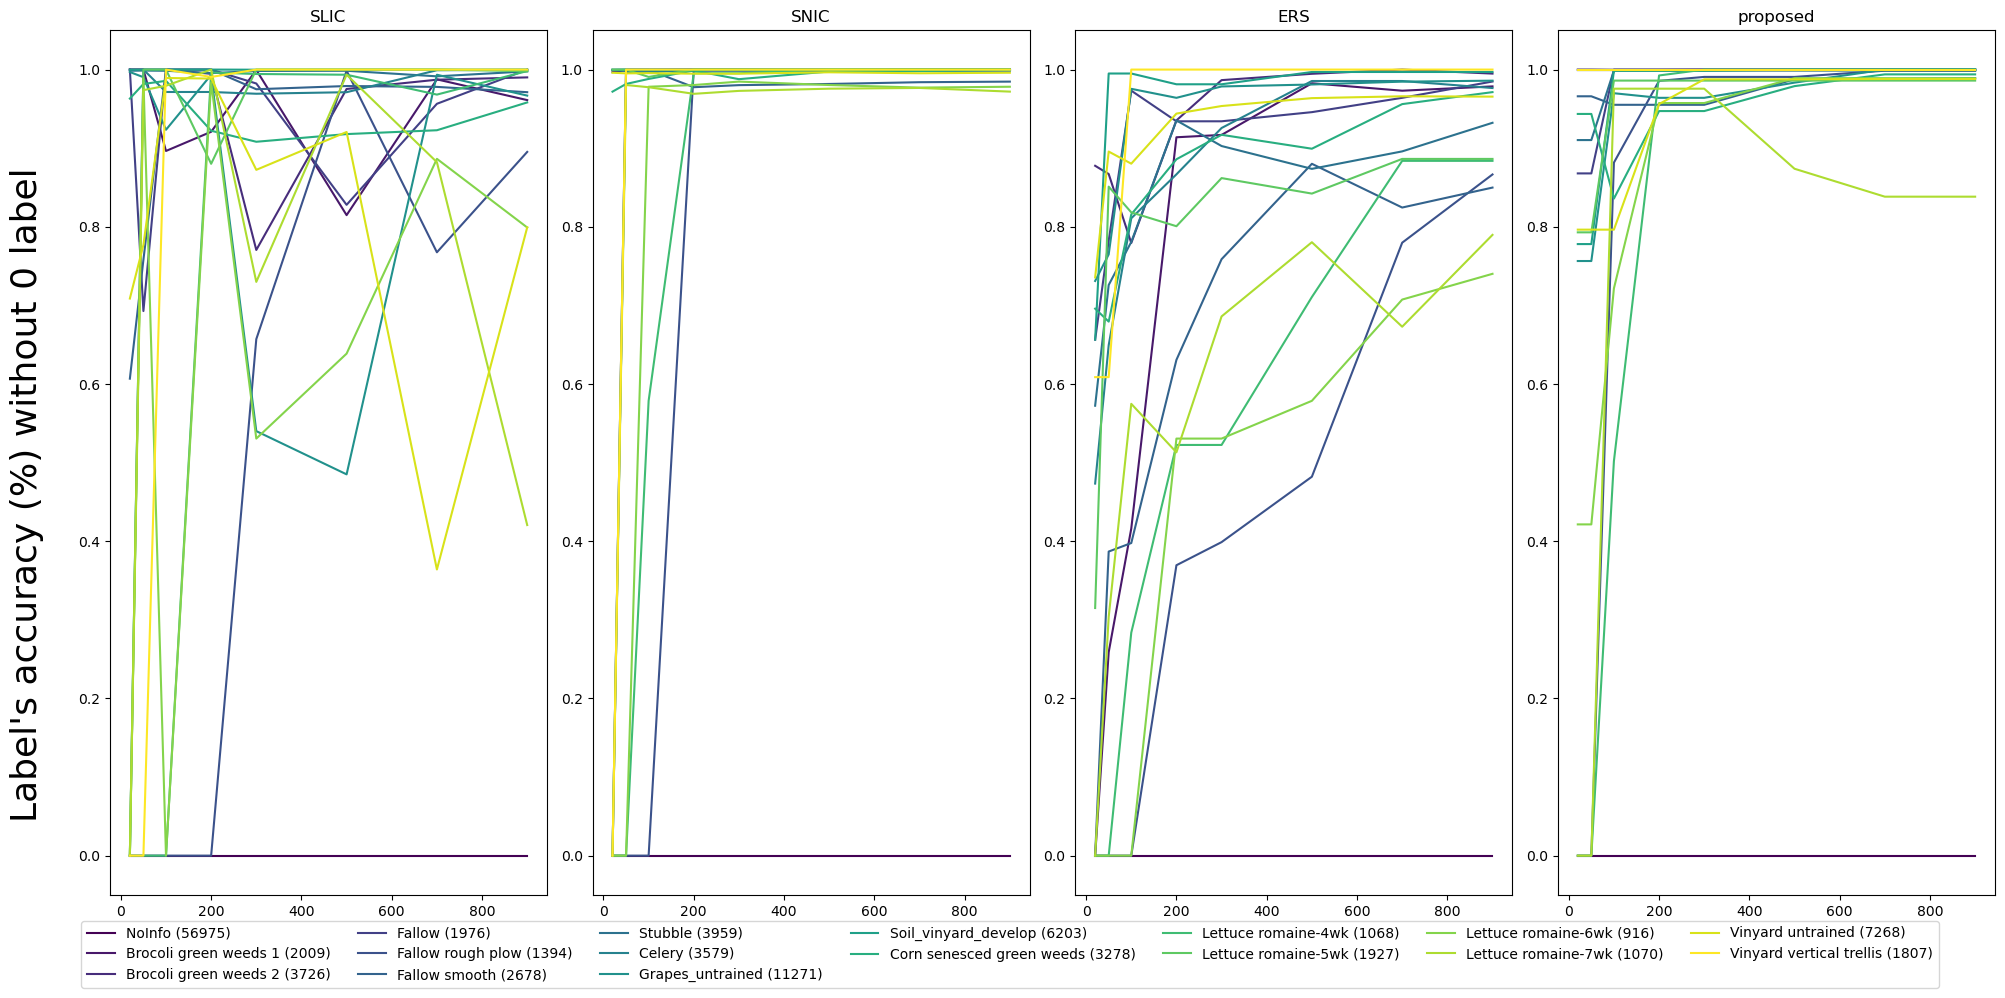

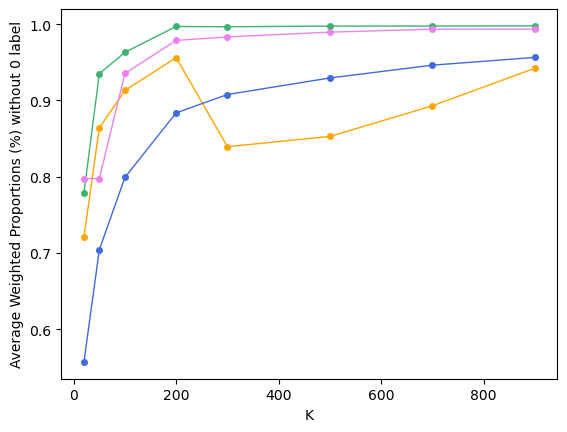

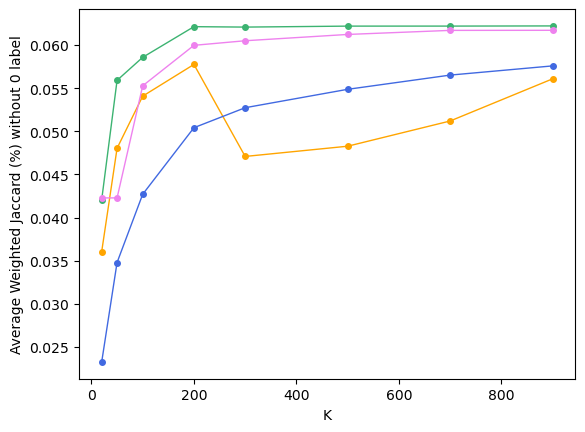

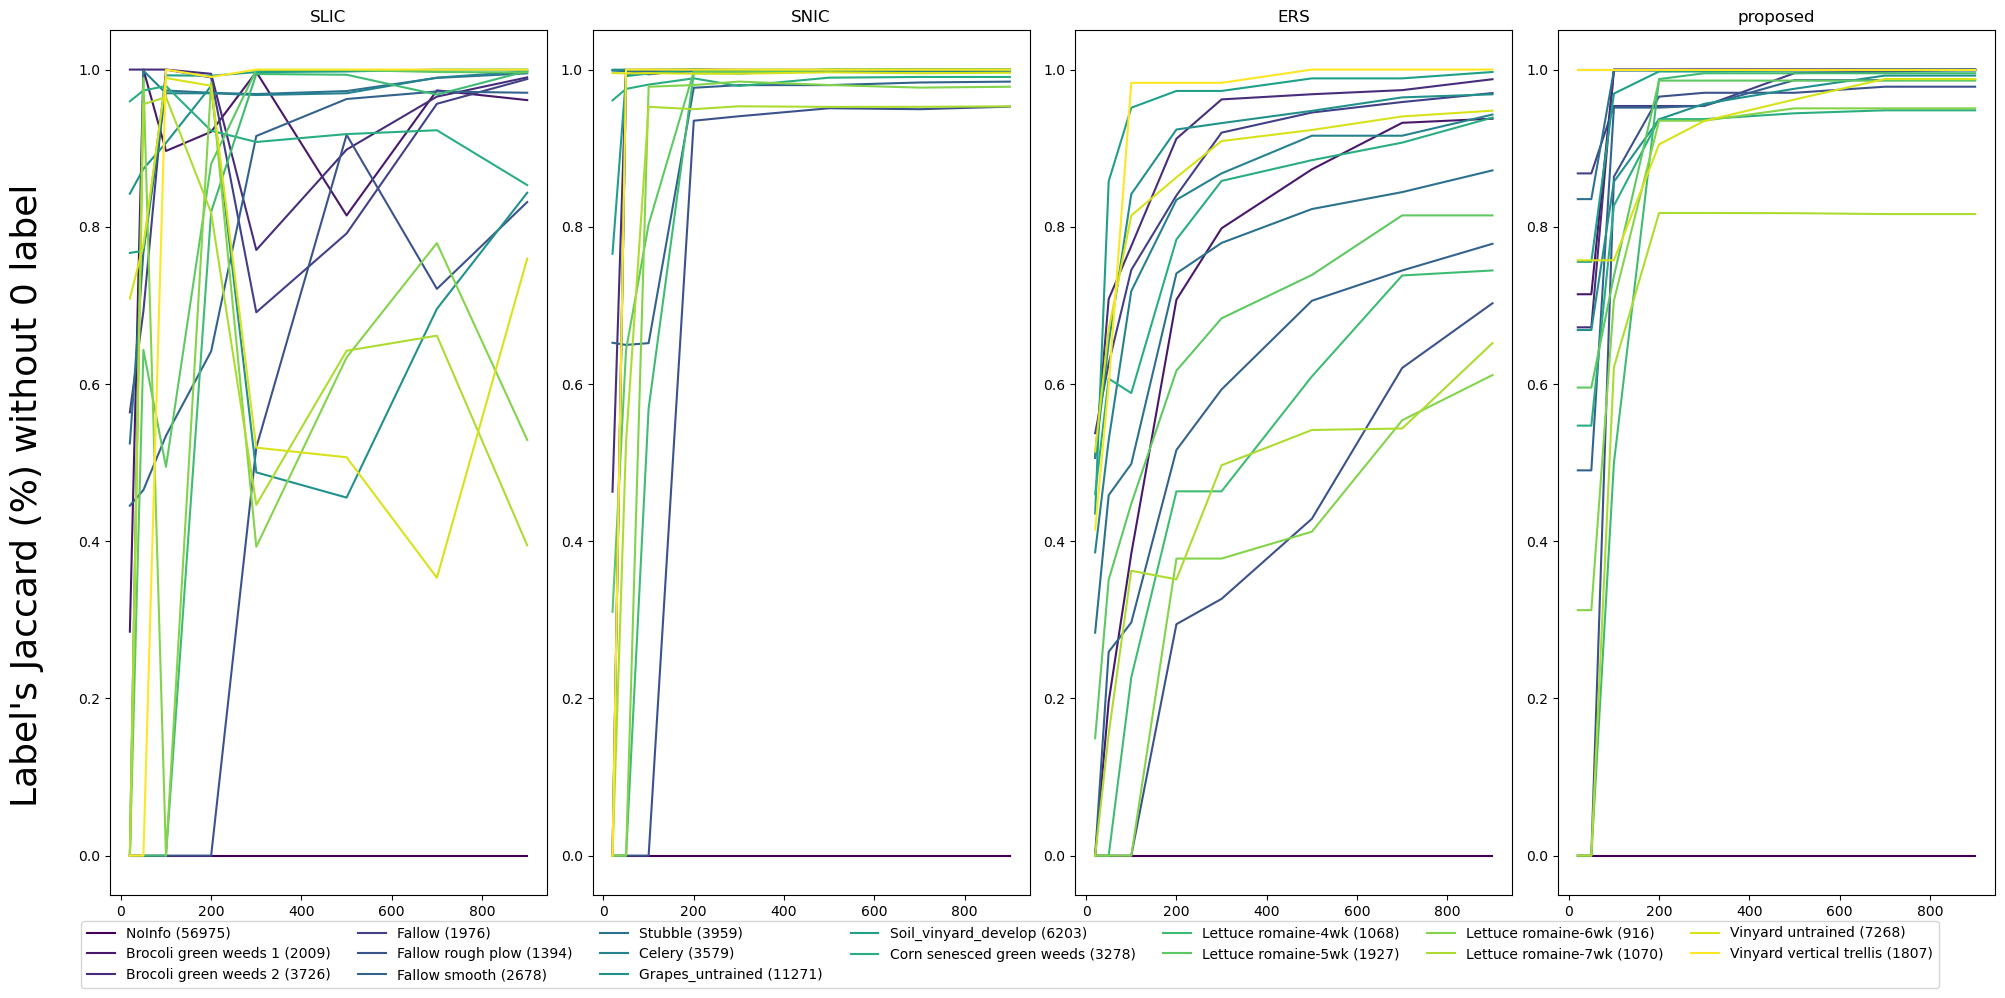

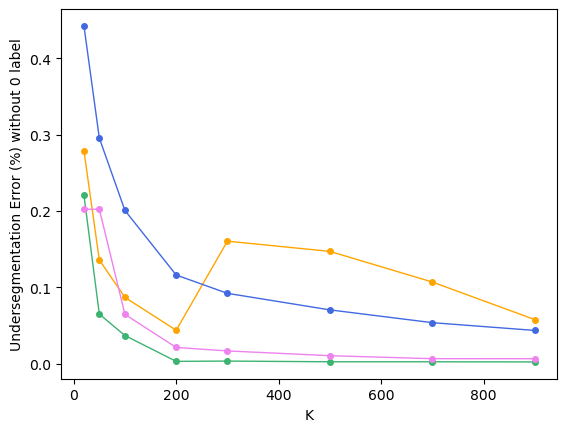

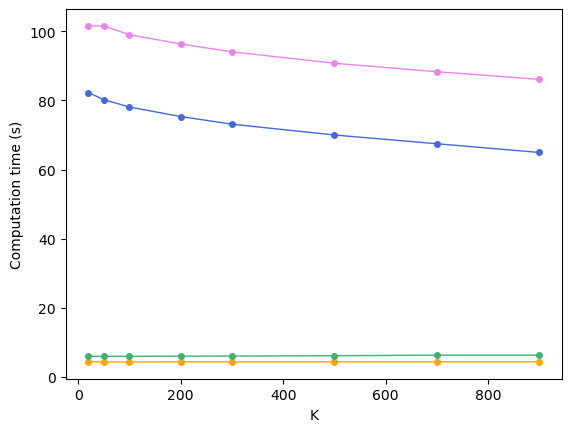

In [10]:
colors = ["black", "gray", "yellow",
            "lightsteelblue", "royalblue", "blue", 
            "lightsalmon", "orangered", "red", "darkred",
            "lightgreen", "springgreen", "seagreen", "darkgreen",
            "pink", "hotpink", "violet", "mediumprchid"
            ]
colors = ["black",
          "lightsteelblue", "royalblue", "blue", 
          "lightsalmon", "orangered", "red",
            "lightgreen", "springgreen", "seagreen",
            "pink", "hotpink", "violet"]
colors = [
        "#81bce7","#4392ca","#2775ac","#114a72","#07253b",
        "#e7be81","#dfa753","#be842c","#8F611C","#583a0c",
        "#81e799","#4ad26a","#21ac42","#117529","#093c15",
        "#c581e7","#ac51d9","#8425b3","#691a91","#2d0840"
]
colors = ["#000000",
          "#81bce7","#3792d3","#0b588f", "#d419e5",
          "#81e799","#32c855","#169533", "#8d0d92"
]
colors = ["orange", "mediumseagreen", "royalblue", "violet", "red"]
#colors = ["black", "#1f77b4", "orange", "violet"]


def plot_info(info, ylabel="", plotbar=False):
    fig, ax = plt.subplots()

    if plotbar:
        for k,K in enumerate(Ks):
            if K!=50:
                for d in range(size):
                    plt.bar(K+ d*20 -20, info[K][d], color=colors[d], width=20)
    else:
        length = len(info[Ks[0]])
        for i in range(length):
            plt.plot(Ks, [info[K][i] for K in Ks], "-o",
                     color=colors[i], linewidth=1, markersize=4)
            
    plt.xlabel("K")
    plt.ylabel(ylabel)
    plt.show()


def plot_label_info(info, ylabel=""):
    fig, axs = plt.subplots(1, len(datas), figsize=(20,10), sharex=True)
    for i in range(len(datas)):
        for label in usedDataset["labels"]:
            if label in info.keys():
                axs[i].plot(Ks, [info[label][K][i] for K in Ks], "-",
                            color=labels_color[label],
                            label=usedDataset["class"][label][0]+" ("+str(len(usedDataset["class"][label][1]))+")")
        axs[i].title.set_text(names[i])
    
    fig.text(0.0, 0.5, ylabel, va='center', rotation='vertical', fontsize=26)

    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=7, bbox_to_anchor=(0.5, -0.0))

    plt.tight_layout()
    plt.subplots_adjust(left=0.05)  
    plt.subplots_adjust(bottom=0.10)
    plt.show()



fig, ax = plt.subplots()

l = [i for i in range(len(datas))]
#l = [0,4,8,1,2,3,5,6,7]
for i in l:
    plt.plot(0,len(datas)-i,"o", color=colors[i], label=names[i])
handles, labels = ax.get_legend_handles_labels()
ncol = len(datas)
ncol = 4
fig.legend(handles, labels, loc='lower center', ncol=ncol, bbox_to_anchor=(0.5, -0.1))

plt.tight_layout()
plt.subplots_adjust(left=0.05)  
plt.subplots_adjust(bottom=0.20)
plt.show()


plotBar = False
motifs = ["-o", "--s", ":^"]
cmap = mpl.colormaps["viridis"]
labels_color = cmap(np.linspace(0, 1, max(usedDataset["labels"])+1))
for b in [True, False]:
    print(b)
    bn = "" if b else " without 0 label"
    plot_info(overallAccuracys[b], "Overall Accuracy (%)"+bn, plotbar=plotBar)
    plot_info(averageAccuracys[b], "Average Accuracy (%)"+bn, plotbar=plotBar)
    plot_label_info(labelsAccuracy[b], "Label's accuracy (%)"+bn)
    #plot_info(singleClassCounts[b], "Unique class proportion (%)"+bn, plotbar=plotBar)
    plot_info(averageWeightedProportions[b], "Average Weighted Proportions (%)"+bn, plotbar=plotBar)
    plot_info(averageWeightedJaccard[b], "Average Weighted Jaccard (%)"+bn, plotbar=plotBar)
    plot_label_info(labelsJaccard[b], "Label's Jaccard (%)"+bn)
    plot_info(undersegmentationErrors[b], "Undersegmentation Error (%)"+bn, plotbar=plotBar)
    #plot_info(undersegmentationErrorsNo[b], "Undersegmentation Error overalpping"+bn, plotbar=plotBar)
    #plot_info(boundaryRecalls[b], "Boundary Recall (%)"+bn, plotbar=plotBar)

if timeDic!={}:
    plot_info(timeDic, "Computation time (s)", plotbar=plotBar)

### GA result

In [28]:
import sklearn.utils
from sklearn.preprocessing import StandardScaler

def split_data(dataset, percent, bands):
    for_slices = [i for i in range(len(bands)) if bands[i]==1]
    X_train = []
    X_test = []
    y_train = []
    y_test = []
    nb_info = sum([len(liste) for key,(_,liste) in dataset["class"].items() if key!=0])
    weights = {}
    for key, (name, liste) in dataset["class"].items():
        if key !=0:
            indices = np.zeros(len(liste), dtype=int)
            indices[:int(len(liste)*percent)] = 1

            np.random.shuffle(indices)

            weights[key] = nb_info/ len(liste)
            
            for i in range(len(liste)):
                data = dataset["data"][liste[i]]
                if indices[i]==1:
                    X_train.append(data[for_slices])
                    y_train.append(key)
                else:
                    X_test.append(data[for_slices])
                    y_test.append(key)

    X_train, y_train = sklearn.utils.shuffle(X_train, y_train, random_state=42)
    X_test, y_test = sklearn.utils.shuffle(X_test, y_test, random_state=42)

    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test), weights
   
    


from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore", category=UserWarning)


def SVM_accuracy(X_train,y_train, X_test,y_test):
    pipeline = Pipeline([
        ('scalar', StandardScaler()),
        ('svc', svm.SVC(kernel='rbf'))
    ])

    param_grid = {
        'svc__C': [0.1, 1, 10, 100, 1000, 2000, 4000],
        'svc__gamma': [1, 0.1, 0.01, 0.001, 0.0005, 0.0001]
    }

    clf = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    return len([0 for i in range(len(y_pred)) if y_pred[i]==y_test[i]]) /len(y_pred)


In [29]:
class Param:
    GN = 100
    NP = 100
    Pc = 0.9
    Pm1 = 0.02
    Pm2 = 0.1

pourcents = {
    Data.IndianPines["name"]: 0.05,
    Data.IndianPinesMerged["name"]: 0.05,
    Data.PaviaUniversity["name"]: 0.02,
    Data.PaviaCenter["name"]: 0.01
}

best_fitness = {K:[0 for _ in range(len(datas))] for K in Ks}
best_accuracy = {K:[0 for _ in range(len(datas))] for K in Ks}

trainingData = usedDataset["data"]

S_list = {K:[SSGA.compute_Sbsp_Stsp_list(trainData, SPsDic[K][i]) for i in range(len(datas))] for K in Ks}
A = 10
for K in Ks:
    print("K:", K)
    for i in range(len(datas)):
        for a in range(A):
            print(a, end=" ")
            pop, fitness = SSGA.SSGA(trainingData, 9, K, Param.GN, Param.NP, Param.Pc, Param.Pm1, Param.Pm2,
                                SP=SPsDic[K][i], S_list=S_list[K][i])
            best_fitness[K][i] += fitness[0]

            bands = pop[0]
            X_train,y_train, X_test,y_test, weights = split_data(usedDataset, pourcents[usedDataset["name"]], bands)
            best_accuracy[K][i] += SVM_accuracy(X_train,y_train, X_test,y_test)

        best_fitness[K][i] /= A
        best_accuracy[K][i] /= A
        print()

KeyboardInterrupt: 

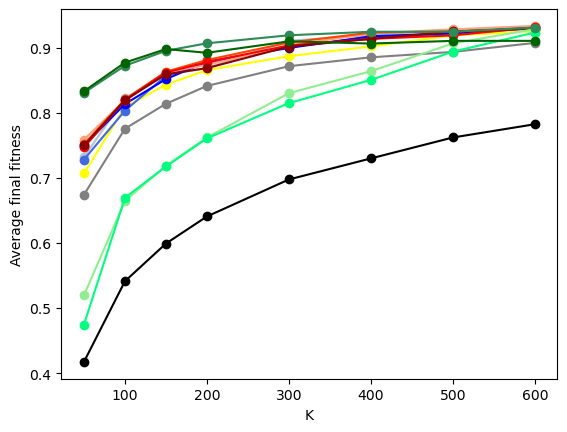

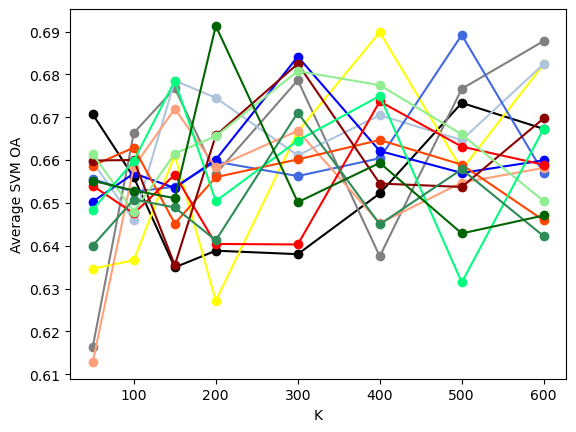

K = 50
[0.6706486042692938, 0.6164408866995075, 0.6346161740558294, 0.6595238095238095, 0.6555316091954022, 0.6502976190476191, 0.6128694581280787, 0.6586925287356322, 0.6539819376026272, 0.6598727422003284, 0.6613711001642035, 0.6483887520525451, 0.6400246305418719, 0.6551518883415435]
K = 100
[0.655952380952381, 0.6663279967159278, 0.6366071428571428, 0.6459051724137932, 0.6525759441707718, 0.656886288998358, 0.6583846469622332, 0.6629002463054187, 0.647536945812808, 0.660016420361248, 0.6479269293924467, 0.6598522167487685, 0.6507697044334975, 0.6528838259441707]
K = 150
[0.6349445812807881, 0.6767446633825943, 0.6612376847290642, 0.6785201149425287, 0.6537972085385879, 0.6534790640394089, 0.6719519704433496, 0.6451662561576355, 0.6565784072249589, 0.6354577175697866, 0.6615147783251232, 0.6785098522167488, 0.6489326765188834, 0.6510981116584565]
K = 200
[0.6388341543513957, 0.6568041871921182, 0.6271346469622332, 0.6745381773399015, 0.6596161740558292, 0.6600882594417078, 0.6583025

In [ ]:
plot_info(best_fitness, "Average final fitness")
plot_info(best_accuracy, "Average SVM OA")
for K in Ks:
    print("K =", K)
    print(best_accuracy[K])